In [37]:
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns

sns.set_theme()

In [2]:
# import packages
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.preprocessing import StandardScaler

#### Setup DB connection

In [2]:
from sqlalchemy import create_engine


def postgresql_engine(user, pwd, host, port, dbname):
    # Need psycopg2-binary package
    sql_engine = create_engine('postgres://' + user + ':' + pwd + '@' + host + ':' + port + '/' + dbname, echo=False)
    return sql_engine

In [3]:
# DB username & password
import getpass

username = getpass.getpass()
password = getpass.getpass()

In [6]:
# misc db parameters
url = 'adds-postgres-dev.cfgztrijqgvp.us-east-1.rds.amazonaws.com'
database = 'musiclab'
port = '5432'

In [7]:
# create DB engine
engine = postgresql_engine(username, password, url, port, database)

#### read in hits tracker

In [8]:
df_hits_tracker = pd.read_pickle('ebw_hits_tracker_h1.pkl')

In [10]:
# define hit tag year
df_hits_tracker['hit_tag_year'] = df_hits_tracker['hit_tag_date'].dt.year

In [ ]:
# define hit spins bucket using existing definitions used by business
df_hits_tracker['hit_spins_bucket_curr'] = pd.cut(df_hits_tracker['cuml_song_station_spins_non_on_at_hit'],
                                                  bins=[0, 200, 500, round(np.max(df_hits_tracker[
                                                                                      'cuml_song_station_spins_non_on_at_hit']) / 100) * 100],
                                                  labels=['early', 'mid', 'late'])

In [32]:
df_hits_tracker['song_release_year'] = df_hits_tracker['song_release_year'].astype(int)

In [33]:
df_hits_tracker['hit_tag_year'] = df_hits_tracker['hit_tag_year'].astype(int)

In [14]:
df_hits_tracker.groupby(['song_release_year'])['mediabase_id'].count()

song_release_year
2017.0    915
2018.0    667
2019.0    650
2020.0    407
2021.0    483
2022.0    233
Name: mediabase_id, dtype: int64

In [20]:
# breakdown by song-release-year and hit-tag-year
df_hits_tracker.groupby(['song_release_year', 'hit_tag_year'])['mediabase_id'].count().reset_index().join(df_hits_tracker.groupby(['song_release_year'])['mediabase_id'].count(), on=['song_release_year'], how='left', rsuffix='_total')

,song_release_year,hit_tag_year,mediabase_id,mediabase_id_total
0,2017.0,2017,509,915
1,2017.0,2018,354,915
2,2017.0,2019,45,915
3,2017.0,2020,1,915
4,2017.0,2021,3,915
5,2017.0,2022,2,915
6,2017.0,2023,1,915
7,2018.0,2018,305,667
8,2018.0,2019,307,667
9,2018.0,2020,41,667


In [40]:
mask_stg = (df_hits_tracker['song_release_year'] < 2022)
df_hits_tracker = df_hits_tracker.loc[mask_stg]

#### Burn by Release Year

In [41]:
df_hit_stg = df_hits_tracker[['mediabase_id', 'call_letters', 'song_release_year', 'spins_to_burnout_from_hit', 'censoring_flg', 'hit_tag_year']].drop_duplicates()

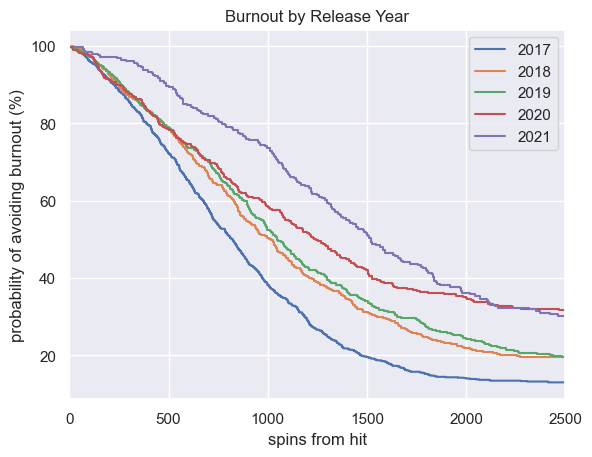

In [58]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

for treatment_type in pd.unique(df_hit_stg['song_release_year']):
    mask_treat = df_hit_stg["song_release_year"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        df_hit_stg["censoring_flg"][mask_treat],
        df_hit_stg["spins_to_burnout_from_hit"][mask_treat].fillna(2500))

    plt.step(time_treatment, 100 * survival_prob_treatment, where="post",
             label=treatment_type)

plt.xlim([0, 2500])
plt.ylabel("probability of avoiding burnout (%)")
plt.xlabel("spins from hit")
plt.legend(loc="best")
plt.title('Burnout by Release Year')
#plt.tight_layout()
plt.savefig('burnout_by_release_year_insights_h1.jpeg', format='jpeg', dpi=300)

#### Burn by Hit Conversion Year

In [69]:
mask_stg = df_hits_tracker['hit_tag_year'] < 2022

In [70]:
df_hit_stg = df_hits_tracker.loc[mask_stg][['mediabase_id', 'call_letters', 'song_release_year', 'spins_to_burnout_from_hit', 'censoring_flg', 'hit_tag_year']].drop_duplicates()

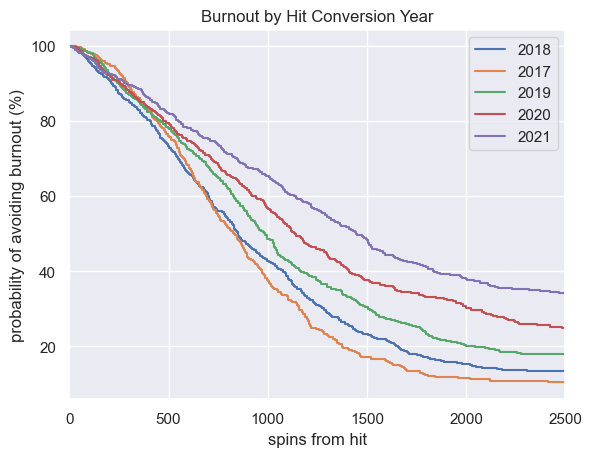

In [71]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

for treatment_type in pd.unique(df_hit_stg['hit_tag_year']):
    mask_treat = df_hit_stg["hit_tag_year"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        df_hit_stg["censoring_flg"][mask_treat],
        df_hit_stg["spins_to_burnout_from_hit"][mask_treat].fillna(2500))

    plt.step(time_treatment, 100 * survival_prob_treatment, where="post",
             label=treatment_type)

plt.xlim([0, 2500])
plt.ylabel("probability of avoiding burnout (%)")
plt.xlabel("spins from hit")
plt.legend(loc="best")
plt.title('Burnout by Hit Conversion Year')
#plt.tight_layout()
plt.savefig('burnout_by_hit_year_insights_h1.jpeg', format='jpeg', dpi=300)

#### Weeks-to-burn and spins-to-burn

In [53]:
df_hits_tracker['weeks_since_hit'] = (pd.to_datetime(df_hits_tracker['ddl_over_thresh_dt_second']) - df_hits_tracker['hit_tag_date'])/np.timedelta64(1, 'W')

In [56]:
mask_post = (df_hits_tracker['song_release_year'] >=2020)

In [54]:
df_hits_tracker['weeks_since_hit']

475        1.0
770       10.0
1069      13.0
1365      12.0
1660       5.0
          ... 
647741     NaN
654398     NaN
654423     NaN
654448     NaN
654473     NaN
Name: weeks_since_hit, Length: 3122, dtype: float64

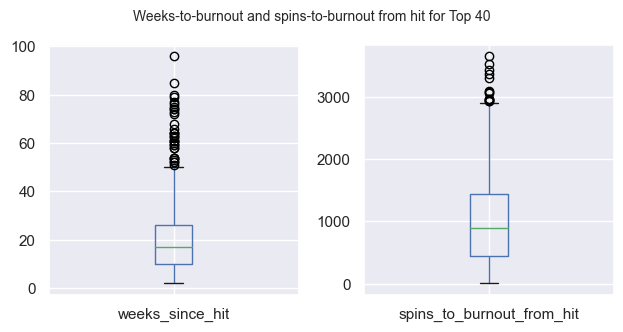

In [60]:
ax1 = plt.subplot(1,2,1)
df_hits_tracker.loc[mask_post]['weeks_since_hit'].plot(kind='box')
ax2 = plt.subplot(1,2,2)
df_hits_tracker.loc[mask_post]['spins_to_burnout_from_hit'].plot(kind='box')

ax1.set_aspect(1/ax1.get_data_ratio())
ax2.set_aspect(1/ax2.get_data_ratio())

plt.suptitle('Weeks-to-burnout and spins-to-burnout from hit for Top 40',y = 0.8, fontsize='small')
plt.tight_layout()
plt.savefig('week_spins_to_burn_from_hit_insights_h1.jpeg', format='jpeg', dpi=300)

In [73]:
df_hit_stg = df_hits_tracker.loc[mask_post]
df_hit_stg=df_hit_stg[~pd.isna(df_hit_stg['hit_spins_bucket_curr'])]

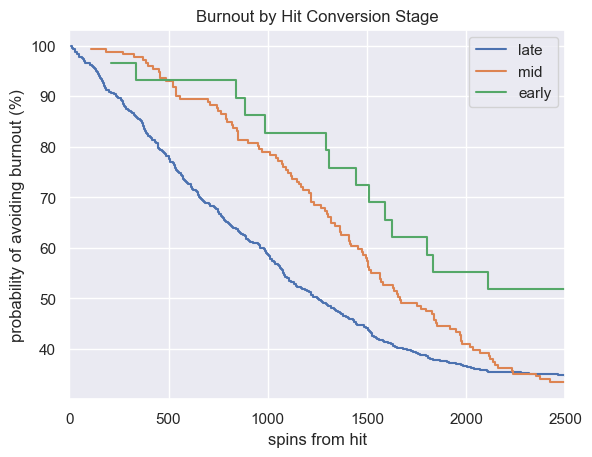

In [74]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

for treatment_type in pd.unique(df_hit_stg['hit_spins_bucket_curr']):
    mask_treat = df_hit_stg["hit_spins_bucket_curr"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        df_hit_stg["censoring_flg"][mask_treat],
        df_hit_stg["spins_to_burnout_from_hit"][mask_treat].fillna(2500))

    plt.step(time_treatment, 100 * survival_prob_treatment, where="post",
             label=treatment_type)

plt.xlim([0, 2500])
plt.ylabel("probability of avoiding burnout (%)")
plt.xlabel("spins from hit")
plt.legend(loc="best")
plt.title('Burnout by Hit Conversion Stage')
#plt.tight_layout()
plt.savefig('burnout_by_hit_stage_insights_h1.jpeg', format='jpeg', dpi=300)

#### Burn by hit spin bucket

In [78]:
df_hits_tracker['hit_spins_bucket_granular'] = pd.cut(df_hits_tracker['cuml_song_station_spins_non_on_at_hit'], bins=[50, 250, 350, 450, 550, 650, 750, 850, 950, 1050, 1150, 1250, 1350, 1450, 1550, 1750, np.max(df_hits_tracker['cuml_song_station_spins_non_on_at_hit'])], labels=['50 to 250', '250 to 350', '350 to 450', '450 to 550', '550 to 650', '650 to 750', '750 to 850', '850 to 950', '950 to 1050', '1050 to 1150', '1150 to 1250', '1250 to 1350', '1350 to 1450', '1450 to 1550', '1550 to 1750', '> 1750'])

In [89]:
df_hits_tracker.loc[mask_post].groupby(['hit_spins_bucket_curr']).agg({'mediabase_id': len, 'weeks_since_hit': np.mean, 'spins_to_burnout_from_hit': np.mean, 'cuml_song_station_spins_non_on_at_burnout': np.mean, 'cuml_song_station_spins_non_on_at_burnout': lambda x: pd.isna(x).sum()})

,mediabase_id,weeks_since_hit,spins_to_burnout_from_hit,cuml_song_station_spins_non_on_at_burnout
hit_spins_bucket_curr,,,,
early,29,30.312500,1517.75000,13.0
mid,171,23.304000,1423.28800,46.0
late,688,19.342733,876.38913,228.0


In [83]:
df_hits_tracker.head()

,mediabase_id,call_letters,song_release_date,song_release_year,ftq_date,hit_tag_date,ddl_over_thresh_dt_first,ddl_over_thresh_dt_second,weeks_bw_ftq_first_spins,weeks_bw_top_quintiles,...,cuml_song_station_spins_non_on_at_hit,cuml_song_station_spins_non_on_at_pre_burnout,cuml_song_station_spins_non_on_at_burnout,spins_to_hit_from_ftq,spins_to_burnout_from_hit,censoring_flg,hit_tag_year,hit_spins_bucket_curr,weeks_since_hit,hit_spins_bucket_granular
475,2211649,KHKS-FM,2017-03-01,2017,2018-02-18,2018-04-29,None,2018-05-06,28.0,10.0,...,1773.0,NaN,1803.0,273.0,30.0,True,2018,late,1.0,> 1750
770,2211649,WDCG-FM,2017-03-01,2017,2017-09-24,2017-10-22,2017-12-03,2017-12-31,11.0,4.0,...,542.0,945.0,1106.0,292.0,564.0,True,2017,late,10.0,450 to 550
1069,2211649,WHTZ-FM,2017-03-01,2017,2017-09-17,2017-10-22,2018-01-14,2018-01-21,7.0,5.0,...,360.0,789.0,818.0,154.0,458.0,True,2017,mid,13.0,350 to 450
1365,2211649,WHYI-FM,2017-03-01,2017,2017-10-01,2017-10-08,2017-10-29,2017-12-31,8.0,1.0,...,221.0,463.0,636.0,57.0,415.0,True,2017,mid,12.0,50 to 250
1660,2211649,WIHT-FM,2017-03-01,2017,2017-11-26,2017-12-31,2018-01-14,2018-02-04,17.0,5.0,...,807.0,872.0,935.0,110.0,128.0,True,2017,late,5.0,750 to 850
